In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
# Normalize
x_train = x_train/255.
y_train = y_train/255.
x_test  = x_test/255.
y_test  = y_test/255.

0.011764705882352941

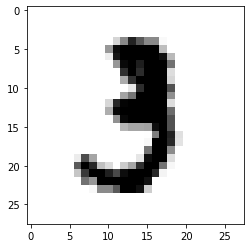

In [5]:
plt.imshow(x_train[10],'gray_r')
y_train[10]

In [6]:
variance = tf.Variable([1.]) # how can we enforce this to be postive and such that 0 < out < 1

def make_prior(latent_params_size):
  means = tf.zeros(latent_params_size)
  stds = tf.ones(latent_params_size)
  return tfd.MultivariateNormalDiag(means, stds)

def make_encoder(data, latent_params_size):
  """
  Input: 
      data - ?, 28, 28
  Output:
      MultivariateNormalDiag ?, latent_params_size
  """
  x = tf.layers.flatten(data)
  x = tf.layers.dense(x, 256, tf.nn.relu)
  x = tf.layers.dense(x, 256, tf.nn.relu)
  means = tf.layers.dense(x, latent_params_size) # the mean can be any real number
  variances = tf.layers.dense(x, latent_params_size, tf.nn.softplus) # the variance needs to be positive
  return tfd.MultivariateNormalDiag(means, variances)

def make_decoder(x, data_shape):
  flat_size = np.prod(data_shape)
  variances = variance*tf.ones(data_shape)
  x = tf.layers.dense(x, 256, tf.nn.relu)
  x = tf.layers.dense(x, 256, tf.nn.relu)
  #means =  tf.reshape(tf.layers.dense(x, flat_size, tf.nn.sigmoid), [-1] + data_shape) # the mean should be between 0 and 1
  means =  tf.reshape(tf.layers.dense(x, flat_size), [-1] + data_shape) # actually not, the distribution is handling this bit
  return tfd.Independent(tfd.MultivariateNormalDiag(means, variances), 2)

make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

In [7]:
# model parameters
learning_rate = 0.001
latent_params_size = 2
# visualisation parameters
n_samples = 15

# model variables
data_placeholder = tf.placeholder(tf.float32, [None, 28, 28])
prior = make_prior(latent_params_size=latent_params_size)
posterior = make_encoder(data_placeholder, latent_params_size=latent_params_size)
latent_placeholder = posterior.sample()
decoder = make_decoder(latent_placeholder, [28, 28])
likelihood = decoder.log_prob(data_placeholder)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
optimize = tf.train.AdamOptimizer(learning_rate).minimize(-elbo)

# visualisation variables
#print("encode")
encodings = posterior.mean()
print(encodings)
#print("decode")
decoded = make_decoder(encodings,  [28, 28]).mean()
#print("sample")
_samples = prior.sample(n_samples)
samples = make_decoder(_samples, [28, 28]).mean()

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.
Tensor("encoder/MultivariateNormalDiag/mean_1/add:0", shape=(?, 2), dtype=float32)


In [8]:
def plot_latent(ax, codes, labels):
  ax.scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1, cmap='tab10')
  ax.set_aspect('equal')
  ax.set_xlim(codes.min() - .1, codes.max() + .1)
  ax.set_ylim(codes.min() - .1, codes.max() + .1)
  ax.tick_params(
      axis='both', which='both', left='off', bottom='off',
      labelleft='off', labelbottom='off')


def plot_samples(ax, samples):
  for index, sample in enumerate(samples):
    ax[index].imshow(sample, cmap='gray')
    ax[index].axis('off')
    
def plot_encode_decode(axe, axd, inputs, outputs):
    for i, (inp, out) in enumerate(zip(inputs, outputs)):
        #print(encoded, decodeds)
        axe[i].imshow(inp, cmap='gray')
        axe[i].axis('off')
        axd[i].imshow(out, cmap='gray')
        axd[i].axis('off')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch 0 elbo -7651504.0
Epoch 5 elbo 1534293.0
Epoch 10 elbo 1711112.4
Epoch 15 elbo 1822536.5
Epoch 20 elbo 1872695.5
Epoch 25 elbo 1881824.9
Epoch 30 elbo 1920304.5
Epoch 35 elbo 1937224.9
Epoch 40 elbo 1959146.5
Epoch 45 elbo 1960244.2
Epoch 50 elbo 1975176.4


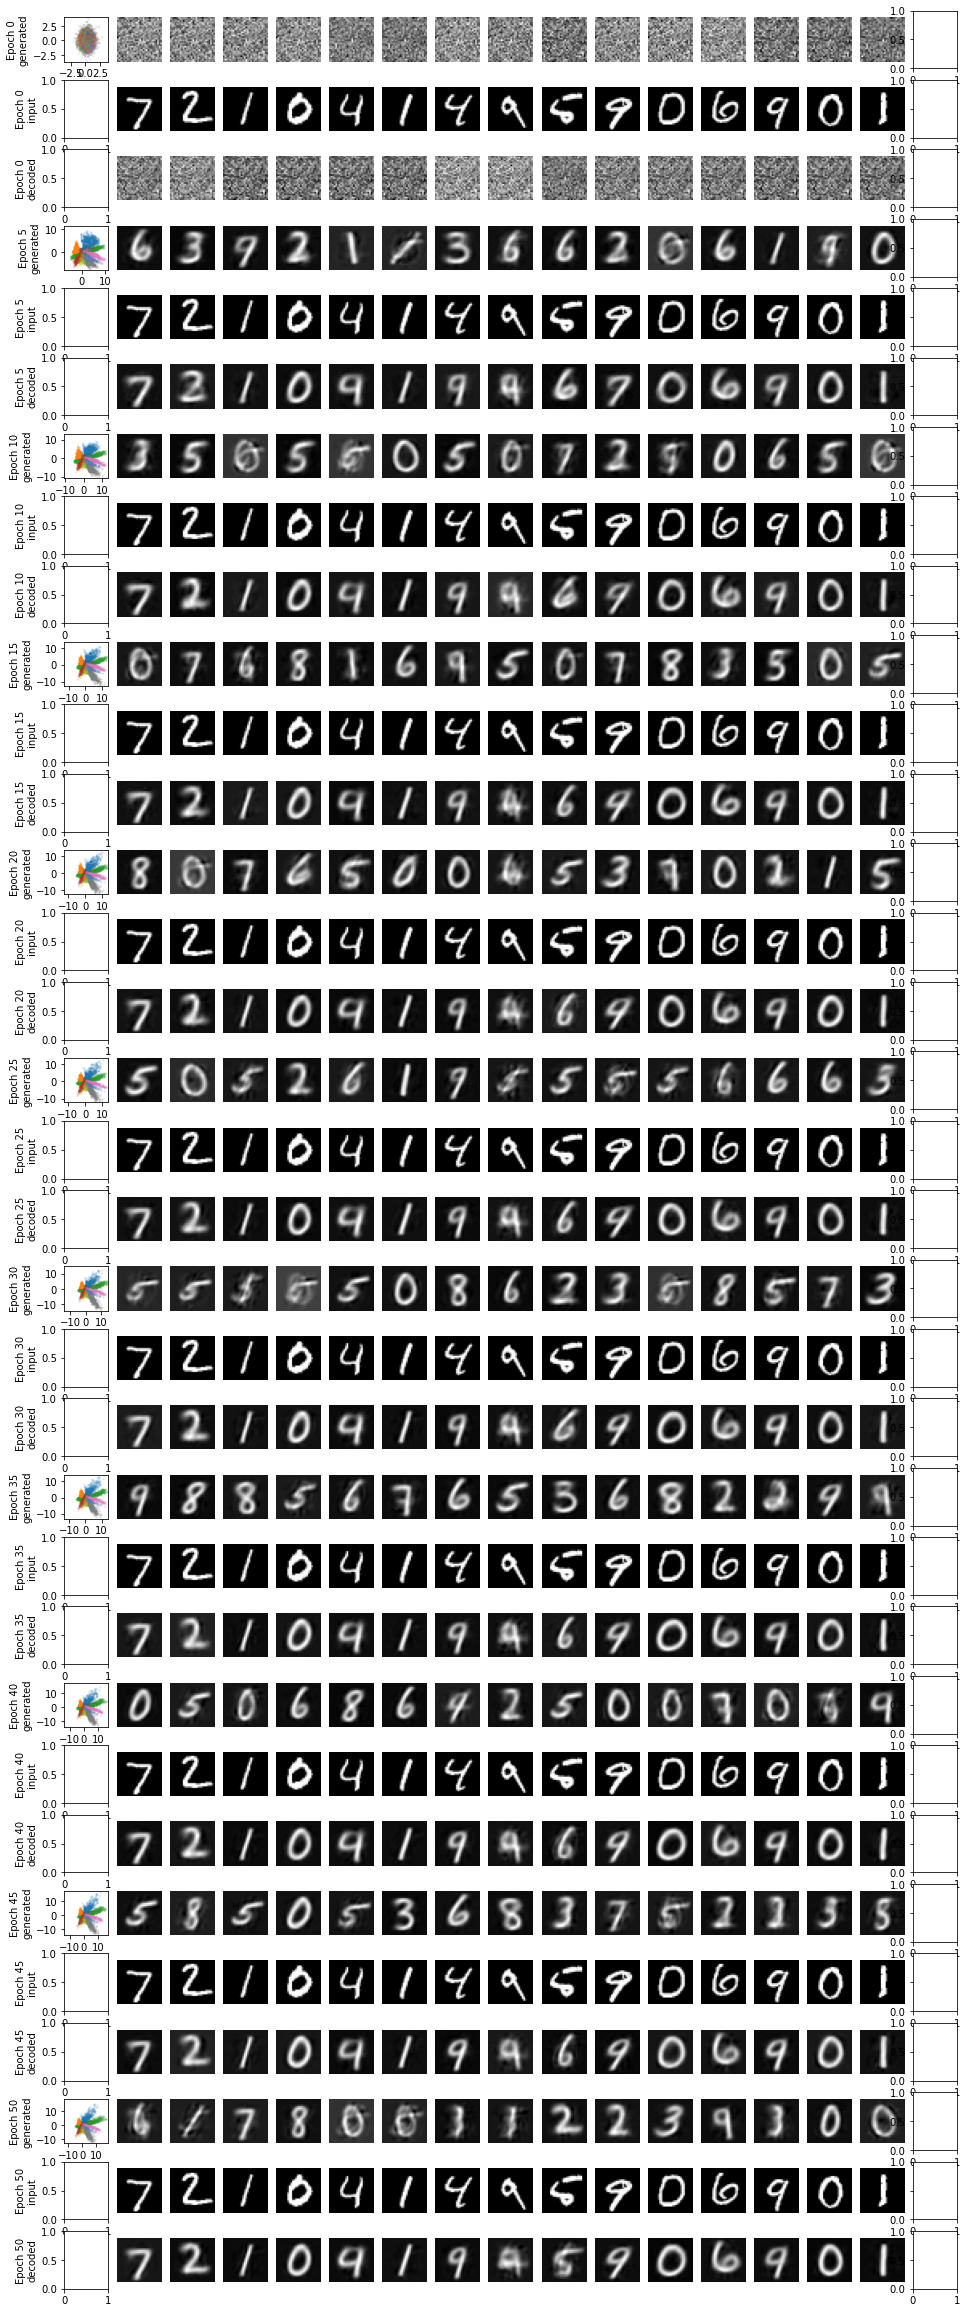

In [9]:
epochs = 50
skip = 5
batch_size = 128
fig, ax = plt.subplots(nrows=3*(epochs//skip+1), ncols=16, figsize=(16, 3*1.27*(epochs // skip+1)))
with tf.train.MonitoredSession() as sess:
    for epoch in range(epochs+1):
        if (epoch % skip == 0):
            start_row = (epoch//skip)*3
            feed = {data_placeholder: x_test}
            test_elbo, test_likelihood, test_divergence, test_latent, test_samples = sess.run([elbo, likelihood, divergence, 
                                                            latent_placeholder, samples], feed)
            test_input = x_test[:n_samples]
            test_decoded = sess.run(decoded, {data_placeholder: test_input})
            print('Epoch', epoch, 'elbo', test_elbo)
            ax[start_row, 0].set_ylabel('Epoch {}\ngenerated'.format(epoch))
            ax[start_row+1, 0].set_ylabel('Epoch {}\ninput'.format(epoch))
            ax[start_row+2, 0].set_ylabel('Epoch {}\ndecoded'.format(epoch))
            plot_latent(ax[start_row, 0], test_latent, y_test)
            plot_samples(ax[start_row, 1:], test_samples)
            plot_encode_decode(ax[start_row+1, 1:], ax[start_row+2, 1:], test_input, test_decoded)
        for i in range(len(x_train)//batch_size):
            feed = {data_placeholder: x_train[batch_size*i:batch_size*(i+1)]}
            sess.run(optimize, feed)
        # shuffle the training  set
        perm = np.arange(len(x_train))
        np.random.shuffle(perm)
        x_train = x_train[perm]
        y_train = y_train[perm]